In [1]:
import sbi
from sbi.inference import SNLE, SNRE, SNPE
import torch

data_store = []

from markovsbi.bm.api_utils import NPEModel, SBIModel


import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt 
import optax

from markovsbi.tasks import get_task
from markovsbi.utils.sde_utils import init_sde
from markovsbi.models.simple_scoremlp import build_score_mlp, precondition_functions
from markovsbi.models.train_utils import build_batch_sampler,build_loss_fn
from markovsbi.bm.api_utils import get_window_torch

sbi.__version__

'0.23.1'

In [255]:

dim = 10
key_number = 4






key = jax.random.PRNGKey(key_number)

task = get_task("simple{}dnonstationary".format(dim))
prior = task.get_prior()
simulator = task.get_simulator()


In [256]:
data = task.get_data(key, 10_000, 2, max_T = 1000)

In [257]:
from numpy import indices

d = task.input_shape[0]

prior_torch = torch.distributions.Independent(torch.distributions.Normal(torch.zeros(d), torch.ones(d)),1)
    
inf = SNRE(prior_torch, classifier = 'resnet')

thetas = data["thetas"]
xs = data["xs"]
ts = data["ts"]

thetas = torch.tensor(np.array(thetas), dtype=torch.float32)
xs = torch.tensor(np.array(xs), dtype=torch.float32)
xs = xs.reshape(xs.shape[0], -1)
ts = torch.tensor(np.array(ts), dtype=torch.float32)

xs = torch.concatenate([xs, ts], dim=1)
T = int(xs.shape[1])



inf.append_simulations(thetas, xs)


density_estimator = inf.train(training_batch_size = 1000, learning_rate=1e-3, validation_fraction=0.1, stop_after_epochs=20, max_num_epochs=2147483647, clip_max_norm=5.0)
posterior = inf.build_posterior( sample_with = 'mcmc', mcmc_method ='slice_np_vectorized', mcmc_parameters = {'num_chains': 100})


 Neural network successfully converged after 87 epochs.

/opt/anaconda3/lib/python3.11/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


In [268]:
xs.shape, thetas.shape

theta_o = prior.sample(key)
num_obs = 2

x_o = torch.tensor(np.array(simulator(key, theta_o, num_obs)))
t_o = torch.tensor(np.arange(num_obs , dtype=jnp.float32)).reshape(-1, 1)

x_o_window = get_window_torch(x_o, 2)
t_o_window = get_window_torch(t_o, 2)
x_o_window  = torch.concatenate([x_o_window, t_o_window], dim=1)


print(x_o_window.shape)

torch.Size([1, 22])


In [269]:
print('window:', x_o_window.shape)

n_samples = 1000
x_o = torch.tensor(np.array(x_o))
posterior._x_shape = (1, x_o.shape[0], x_o.shape[1])
#posterior.posterior_estimator._condition_shape = x_o.shape
samples = posterior.sample((n_samples,), x=x_o_window, show_progress_bars=False)



#samples = posterior.sample((1000,), x=x_o)

window: torch.Size([1, 22])
input_x_shape: torch.Size([1, 22])
x_event_shape: None
input_x_shape: torch.Size([1, 22])
x_event_shape: None


In [270]:


true_posterior = task.get_true_posterior(jnp.array(np.array(x_o)))
true_samples = true_posterior.sample(key, (1000,))   
true_samples = torch.tensor(np.array(true_samples)) 

from sbi.utils.metrics import c2st 

distance = c2st(torch.tensor(np.array(samples))[:1000], true_samples[:1000])


10
(1, 10)
(1, 10)


/var/folders/wt/2fn1yjbn3rd4mbn_1xf9746w0000gn/T/ipykernel_95978/2449243716.py:4: UserWarning: offdiag is deprecated, use upper or lower instead.
  _ = pairplot([np.array(samples), true_samples], points = np.array(theta_o), limits = [(-5,5)]*10, offdiag="scatter")


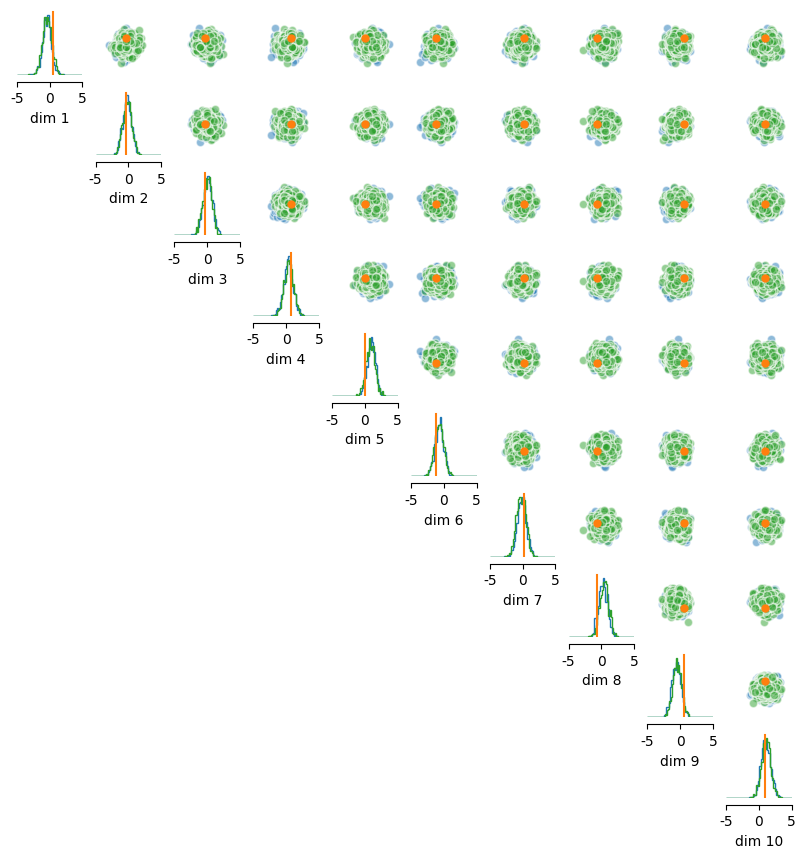

In [271]:
from sbi.analysis import pairplot
import numpy as np

_ = pairplot([np.array(samples), true_samples], points = np.array(theta_o), limits = [(-5,5)]*10, offdiag="scatter")

In [272]:
data_store_local = []


data_store_local.append(dim)
data_store_local.append(key_number)
data_store_local.append(num_obs)
data_store_local.append(distance)

data_store.append(np.array(data_store_local))
#print(data_store_local)

#print(data_store)



import pandas as pd

sample = pd.DataFrame(data_store, columns=['dim', 'key_number', 'obs_length','C2ST'])
print(sample)
sample.to_csv('Nonstationary_{}_101k.csv'.format("NRE"))

     dim  key_number  obs_length    C2ST
0    1.0         0.0         2.0  0.5390
1    1.0         0.0        11.0  0.7615
2    1.0         0.0       101.0  0.9375
3    1.0         1.0       101.0  1.0000
4    1.0         1.0        11.0  0.9330
5    1.0         1.0         2.0  0.5075
6    1.0         2.0       101.0  0.9745
7    1.0         2.0        11.0  0.5565
8    1.0         2.0         2.0  0.5165
9    1.0         3.0       101.0  0.9875
10   1.0         3.0        11.0  0.7985
11   1.0         3.0         2.0  0.5175
12   1.0         4.0       101.0  0.8940
13   1.0         4.0        11.0  0.6105
14   1.0         4.0         2.0  0.4725
15   2.0         0.0       101.0  1.0000
16   2.0         0.0        11.0  0.9005
17   2.0         0.0         2.0  0.5510
18   2.0         1.0       101.0  0.9980
19   2.0         1.0        11.0  0.9875
20   2.0         1.0         2.0  0.5385
21   2.0         2.0       101.0  1.0000
22   2.0         2.0        11.0  0.8040
23   2.0        